In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import optim
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import gc

In [2]:
#Params
input_size=500
batch_size=256
nbr_epochs=5
data_split_ratio=0.8
y_column = "600s"
files_x = ["data/x_Swedbank_A_500_p.csv",
           "data/x_SEB_A_500_p.csv",
           "data/x_Nordea_Bank_Abp_500_p.csv"]
files_y = ["data/y_Swedbank_A_500.csv",
           "data/y_SEB_A_500.csv",
           "data/y_Nordea_Bank_Abp_500.csv"]

In [3]:
def splitData(xs, ys, trainRatio):
    t = round(len(xs)*trainRatio)
    
    train_data_x = torch.tensor(xs[:t].values, dtype=torch.float32)
    train_data_y = torch.tensor(ys[:t].values, dtype=torch.float32)
    
    d = round(len(xs[t:])/2)
    
    dev_data_x = torch.tensor(xs[t:][:d].values, dtype=torch.float32)
    dev_data_y = torch.tensor(ys[t:][:d].values, dtype=torch.float32)
    
    test_data_x = torch.tensor(xs[t:][d:].values, dtype=torch.float32)
    test_data_y = torch.tensor(ys[t:][d:].values, dtype=torch.float32)
    
    #print(test_data_y.shape)
    
    return TensorDataset(train_data_x, train_data_y), TensorDataset(dev_data_x, dev_data_y), list(zip(test_data_x, test_data_y))

In [4]:
#compute_unit = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device('cuda:0')
#device = torch.device("cpu")
#compute_unit = "cpu"

In [5]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

In [6]:
class StockModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 1000).type(dtype)
        self.fc2 = nn.Linear(1000, 2000).type(dtype)
        self.fc3 = nn.Linear(2000, 1000).type(dtype)
        self.fc4 = nn.Linear(1000, 500).type(dtype)
        self.fc5 = nn.Linear(500, 100).type(dtype)
        self.fc6 = nn.Linear(100, 20).type(dtype)
        self.fc7 = nn.Linear(20, 1).type(dtype)
        
        self.drop_layer = nn.Dropout(p=0.010)
    
    def forward(self, x):
        #print(x)
        fc1 = self.fc1(x)
        x = F.relu(fc1)
        x = self.drop_layer(x)
        #print(fc1)
        #print(x)
        x = F.relu(self.fc2(x))
        x = self.drop_layer(x)
        #print(x)
        x = F.relu(self.fc3(x))
        x = self.drop_layer(x)
        #x = self.drop_layer(x)
        #print(x)
        x= F.relu(self.fc4(x))
        #print(y)
        x = F.relu(self.fc5(x))
        x = self.drop_layer(x)
        x = F.relu(self.fc6(x))
        y = F.relu(self.fc7(x))
        return y

model = StockModel(input_size)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [7]:
def evaluate_model(data, model, loss_fn):
    losses = []
    predictions = []
    model.eval()
    with torch.no_grad():
        for x, y in data:
            y = y.squeeze().type(dtype)
            x = x.squeeze().type(dtype)
            pred = model(x)
            loss = loss_fn(pred, y)
            losses.append(loss.item())
            predictions.extend(pred.tolist())
        avg_loss = sum(losses)/len(losses)    
    
    return avg_loss, predictions

In [8]:
def train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, epochrange, batchsize):
    for epoch in range(epochrange):
        losses = []
        n_correct = 0
        model.train()
        for x, y in train_data_loader:
            y = y.type(dtype)
            x = x.type(dtype)
            
            pred = model(x)

            loss = loss_fn(pred, y)
            
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()    

        # Compute accuracy and loss in the entire training set
        train_avg_loss = sum(losses)/len(losses)    
        
        dev_avg_loss,_ = evaluate_model(dev_data_loader, model, loss_fn)
        
        # Display metrics
        display_str = 'Epoch {} '
        display_str += '\tLoss: {:.3f} '
        display_str += '\tLoss (val): {:.3f}'
        print(display_str.format(epoch, train_avg_loss, dev_avg_loss))

In [9]:
#Start training
for i in range(len(files_x)):
    x_data = pd.read_csv(files_x[i], sep=";", dtype="float32", usecols = [j for j in range(input_size)])
    y_data = pd.read_csv(files_y[i], sep=";", dtype="float32", converters = {'ts': int})
    y_data = y_data[y_column]
    print(x_data.shape)
    print(y_data.shape)
    x_data.head()
    y_data.head()
    print(files_x[i])
    train_data, dev_data, test_data = splitData(x_data, y_data, data_split_ratio)
    train_data_loader = DataLoader(train_data, batch_size=batch_size)
    dev_data_loader = DataLoader(dev_data, batch_size=batch_size)
    model = model.to(device)
    train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, nbr_epochs, batch_size)
    del [[x_data, y_data, train_data, dev_data, train_data_loader, dev_data_loader]]
    gc.collect()



<ipython-input-9-6d2fa0af7d50>:4: ParserWarning: Both a converter and dtype were specified for column ts - only the converter will be used
  y_data = pd.read_csv(files_y[i], sep=";", dtype="float32", converters = {'ts': int})


(1770304, 500)
(1770304,)
data/x_Swedbank_A_500_p.csv


/home/oscar/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oscar/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([51])) that is different to the input size (torch.Size([51, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oscar/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([134])) that is different to the input size (torch.Size([134, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the sam

Epoch 0 	Loss: 78.888 	Loss (val): 2.179
Epoch 1 	Loss: 7.010 	Loss (val): 6.501
Epoch 2 	Loss: 6.568 	Loss (val): 3.843
Epoch 3 	Loss: 5.980 	Loss (val): 1.150
Epoch 4 	Loss: 5.879 	Loss (val): 0.168
(1739761, 500)
(1739761,)
data/x_SEB_A_500_p.csv


/home/oscar/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([193])) that is different to the input size (torch.Size([193, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oscar/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([152])) that is different to the input size (torch.Size([152, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 	Loss: 1.114 	Loss (val): 1.878
Epoch 1 	Loss: 1.168 	Loss (val): 4.544
Epoch 2 	Loss: 1.121 	Loss (val): 2.080
Epoch 3 	Loss: 1.128 	Loss (val): 3.770
Epoch 4 	Loss: 1.118 	Loss (val): 3.358
(1779559, 500)
(1779559,)
data/x_Nordea_Bank_Abp_500_p.csv


/home/oscar/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oscar/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 	Loss: 0.652 	Loss (val): 0.778
Epoch 1 	Loss: 0.639 	Loss (val): 0.556
Epoch 2 	Loss: 0.623 	Loss (val): 0.823
Epoch 3 	Loss: 0.633 	Loss (val): 0.500
Epoch 4 	Loss: 0.631 	Loss (val): 0.756


In [10]:
_, preds = evaluate_model(test_data, model, loss_fn)

/home/oscar/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


70.1670150756836


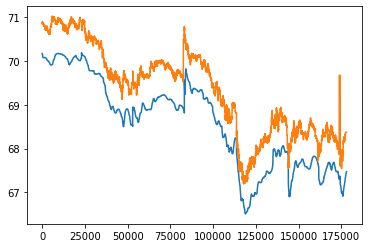

In [13]:
y_data_borpi = list(zip(*test_data))
print(preds[0])
items_plot = [y_data_borpi[1][t] for t in range(len(y_data_borpi[1]))]
plt.plot(list(range(len(preds))), preds)
plt.plot(list(range(len(items_plot))), items_plot)
axes = plt.gca()
#axes.set_ylim([145,170])
#axes.set_xlim([250000,265000])
#axes.set_xlim([100000,120000])
#axes.set_xlim([140000,160000])
plt.show()